In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
# Pretty display for notebooks
%matplotlib inline

In [2]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points
from scipy import stats
from scipy.stats import norm, skew #for some statistic
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [3]:
# Read data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


KeyError: 'LivingArea'

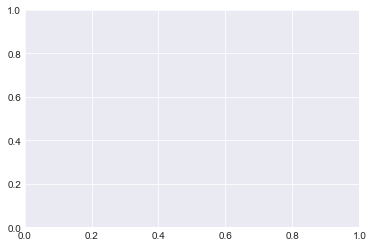

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = train['LivingArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LivingArea', fontsize=13)
plt.show()

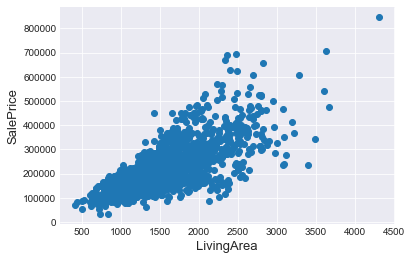

In [5]:
train = train.drop(train[(train['LivingArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['LivingArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LivingArea', fontsize=13)
plt.show()


 mu = 12.21 and sigma = 0.37



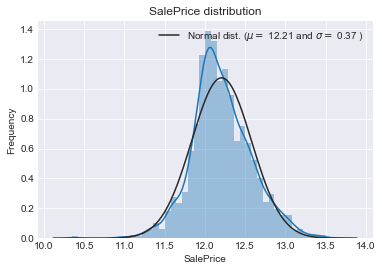

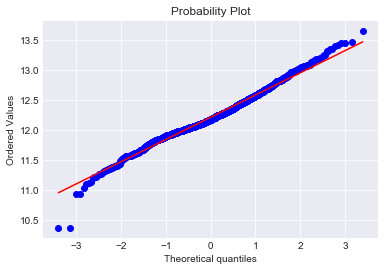

In [6]:
# Log-transformation of the target variable

#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [7]:
ntrain = train.shape[0]
ntest = test.shape[0]
y = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2927, 79)


In [8]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

In [9]:
missing_data

,Missing Ratio
PoolQuality,99.590
Misc Feature,96.413
TypeOfAlleyAccess,93.235
FenceQuality,80.458
FireplaceQuality,48.582
LotFrontage,16.741
GarageYearBuilt,5.432
GarageQuality,5.432
GarageFinish,5.432
GarageCondition,5.432


In [10]:
all_data["PoolQuality"] = all_data["PoolQuality"].fillna("None")

In [11]:
all_data["Misc Feature"] = all_data["Misc Feature"].fillna("None")

In [12]:
all_data["TypeOfAlleyAccess"] = all_data["TypeOfAlleyAccess"].fillna("None")

In [13]:
all_data["FenceQuality"] = all_data["FenceQuality"].fillna("None")

In [14]:
all_data["FireplaceQuality"] = all_data["FireplaceQuality"].fillna("None")

In [15]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood

all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQuality', 'GarageCondition'):
    all_data[col] = all_data[col].fillna('None')

In [17]:
for col in ('GarageYearBuilt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinish1Area', 'BsmtFinish2Area', 'BsmtUnfinishedArea','TotalBsmtArea', 'BsmtFullBaths', 'BsmtHalfBaths',
           'BsmtHeight'):
    all_data[col] = all_data[col].fillna(0)
    

In [19]:
for col in ('BsmtCondition', 'BsmtFinishType1', 'BsmtFinishType2','BsmtExposure'):
    all_data[col] = all_data[col].fillna('None')
    

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [21]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [22]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
LotFrontage,0.102


In [23]:
all_data['LotFrontage'] = all_data['LotFrontage'].fillna(0)

In [24]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [25]:
#Year and month sold are transformed into categorical features.
all_data['YearrSold'] = all_data['YearSold'].astype(str)
all_data['MonthSold'] = all_data['MonthSold'].astype(str)

In [26]:
# Adding total sqfootage feature 
all_data['TotalArea'] = all_data['TotalBsmtArea'] + all_data['1stFloorArea'] + all_data['2ndFloorArea']

In [27]:
features = all_data.columns.values
numeric_feats = []
categoric = []
for col in features:
    if all_data[col].dtype == 'object':
        categoric.append(col)
    else:
        numeric_feats.append(col)

In [28]:
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Misc,22.221
PoolSize,17.719
LotSize,13.179
LowQualityFinishArea,12.106
SeasonPorchArea,11.392
Kitchens,4.309
EnclosedPorchArea,4.010
ScreenPorchArea,3.953
BsmtHalfBaths,3.952
BsmtFinish2Area,3.951


In [29]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])


There are 36 skewed numerical features to Box Cox transform


In [30]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2927, 333)


In [31]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# GBR

In [32]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# import xgboost as xgb
# import lightgbm as lgb

In [35]:
from sklearn import linear_model

In [48]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [49]:
lasso = make_pipeline(RobustScaler(), linear_model.LassoCV(alphas=(0.001,0.0009,0.0008,0.0007, 0.0006, 0.0005),
                           cv=5))

In [50]:
ENet = make_pipeline(RobustScaler(), linear_model.ElasticNetCV(alphas=(0.001,0.0009,0.0008,0.0007, 0.0006, 0.0005),
                           cv=5))

In [51]:
KRR = KernelRidge(alpha=15, kernel='polynomial', degree=2, coef0=2.5)

In [52]:
GBoost = GradientBoostingRegressor(n_estimators=450, learning_rate=0.05,
                                   max_depth=2,
                                    min_samples_split=6, 
                                   loss='huber')

In [53]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [54]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1003 (0.0023)



In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [55]:
averaged_models.fit(train.values, y)
stacked_train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y, stacked_train_pred))

0.08979463697560543


# SUBMIT

In [56]:
# create submission file
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submission.csv',index=False)